In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### image preparation functions

In [6]:
def to_binary(img): 
    binary = np.zeros(img.shape[:2], dtype=int8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j].all() > 0:
                binary[i,j]= 0
            else:
                binary[i,j] = 255
                

def to_bw(img): 
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j].all() > 0:
                img[i,j]= [0,0,0]
            else:
                img[i,j] = [255,255,255]


                
def digits_to_image(matrix, zero, one):
    lines = []
    for i in range(matrix.shape[0]):
        items = []
        for j in range(matrix.shape[1]):
            if matrix[i,j]== 0:
                items.append(zero)
            elif matrix[i,j]== 1:
                items.append(one)
            else:
                raise Exception(f"undefined digit on ({i},{j})")
        lines.append(np.concatenate(items, axis=1))
    full_img = np.concatenate(lines, axis=0)
    return full_img


def image_to_digits(image, zero, one):
    x_step = zero.shape[0]
    y_step = zero.shape[1]
    x_len = image.shape[0]//zero.shape[0]
    y_len = image.shape[1]//zero.shape[1]
    print(f"vertical steps: {x_len}, horisontal steps {y_len}")
    image_names = np.zeros((x_len, y_len), dtype=np.int8)
    penalties = np.zeros((x_len, y_len, 2), dtype=np.int16)
    for x in range(x_len):
        for y in range(y_len):
            penalty0 = 0
            penalty1 = 0
            for i in range(zero.shape[0]):
                for j in range(zero.shape[1]):
                    if image[x * x_step + i, y * y_step + j].any() != zero[i, j].any():
                        penalty0 +=1
                    if image[x * x_step + i, y * y_step + j].any() != one[i, j].any():
                        penalty1 +=1
            image_names[x,y] = (1 if penalty1 < penalty0 else 0)
            penalties[x,y] = [penalty0, penalty1]
    return image_names, penalties

### CYK problem solving functions

In [10]:
def add_noise(array, prob=0.2):
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            array[i, j]=(array[i, j] + np.random.choice([255, 0], size=1, p=[prob, 1-prob])) % 510


            
def find_all_penalties(penalties, imgs_x1, grammar_len):
    #1 find penalties for each column case
    full_img_penalties = np.zeros((imgs_x1, grammar_len), dtype=float)
    for i in range(full_img_penalties.shape[0]):
        for j in range(full_img_penalties.shape[1]):    
            lower_k = j % 2
            middle_k = (j // 2) % 2
            higher_k = (j // 4) % 2
            full_img_penalties[i, j] = (
                penalties[2, i, lower_k]  +
                penalties[1, i, middle_k] +
                penalties[0, i, higher_k]
            )
    #2 find available for the last column
    for j, val in enumerate(require_rest):
        if val==1:
            full_img_penalties[-1, j] = np.inf
    #3 find available for the last column
    for j, val in enumerate(leave_rest):
        if val==1:
            full_img_penalties[0, j] = np.inf
            
    return full_img_penalties



def fing_markup(penalties_matrix, require_rest, leave_rest, verbose=2):
    idx_leave_rest = np.where(leave_rest == 1)
    idx_not_leave_rest = np.where(leave_rest == 0)
    for i in range(penalties_matrix.shape[0]-2, -1, -1):
        prev_penalty_leave_rest = penalties_matrix[i+1, idx_leave_rest].min()
        prev_penalty_not_leave_rest = penalties_matrix[i+1, idx_not_leave_rest].min()
        for this_col in range(penalties_matrix.shape[1]):
            if require_rest[this_col] == 1:
                penalties_matrix[i, this_col] = penalties_matrix[i, this_col] + prev_penalty_leave_rest
            if require_rest[this_col] == 0:
                penalties_matrix[i, this_col] = penalties_matrix[i, this_col] + prev_penalty_not_leave_rest
    if verbose ==2:
        print(f"\npenalties_matrix\n {penalties_matrix}")
        
    min_penalty_idx = []
    for i in range(penalties_matrix.shape[0]):
        if np.min(penalties_matrix[i, :]) != np.inf:
            min_penalty_idx.append(np.argmin(penalties_matrix[i, :]))
        else:
            raise Exceptionon("incorrect input example!")
    if verbose >=1:
        print(f"\nmin_penalty_idx\n {min_penalty_idx}")
        
    result_matrix = np.zeros((3, len(min_penalty_idx)))
    for i in range(result_matrix.shape[1]):
        result_matrix[2, i] =  min_penalty_idx[i] % 2
        result_matrix[1, i] = (min_penalty_idx[i] // 2) % 2
        result_matrix[0, i] = (min_penalty_idx[i] // 4) % 2

    return result_matrix

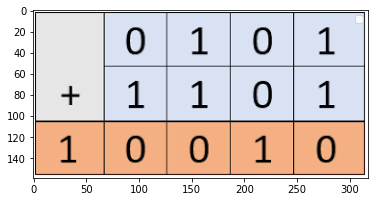

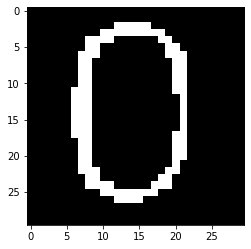

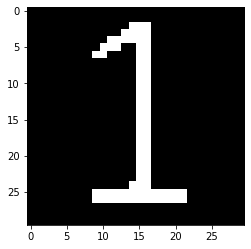

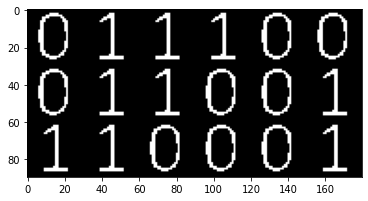

In [42]:
image = Image.open('./images/lab4.png').convert('RGB')
img_tenzor = np.asarray(image)
plt.imshow(img_tenzor)
plt.show()
to_bw(img_tenzor)
zero = img_tenzor[15:45, 83:113]
one = img_tenzor[15:45, 143:173]

plt.imshow(zero)
plt.show()
plt.imshow(one)
plt.show()


example = np.array([[0,1,1,1,0,0],
                    [0,1,1,0,0,1],
                    [1,1,0,0,0,1]])

full_img = digits_to_image(example, zero, one)
plt.imshow(full_img)
plt.show()

In [ ]:
# Image.fromarray(one).save("./images/one.png")
# Image.fromarray(zero).save("./images/zero.png")
# Image.fromarray(full).save("./images/full.png")

 img shape (90, 180, 3)


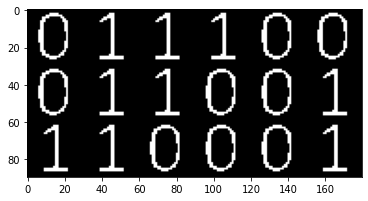

In [20]:
image = Image.open('./images/full.png')
zero = Image.open('./images/zero.png')
one = Image.open('./images/one.png')

img_tenzor = np.asarray(image)
zero = np.asarray(zero)
one = np.asarray(one)

shape = img_tenzor.shape
print(f' img shape {shape}')

plt.imshow(img_tenzor)
plt.show()

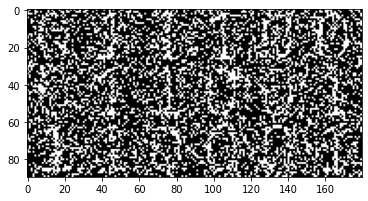

In [21]:
add_noise(img_tenzor, prob=0.3)
plt.imshow(img_tenzor)
plt.show()

In [22]:
labels, penalties = image_to_digits(img_tenzor, zero, one)
labels

vertical steps: 3, horisontal steps 6


array([[0, 1, 1, 1, 0, 0],
       [0, 1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0, 1]], dtype=int8)

In [23]:
#Grammar

# 0 1 2 3 4 5 6 7

# 0 0 0 0 1 1 1 1   0
# 0 0 1 1 0 0 1 1   1
# 0 1 0 1 0 1 0 1   2

# E E E'E E'E E'E'

require_rest = arr = np.array([0, 1, 1, 0, 1, 0, 0, 1])
leave_rest = arr = np.array([0, 0, 1, 0, 1, 0, 1, 1])

In [24]:
penalties_matrix = find_all_penalties(penalties, imgs_x1=labels.shape[1], grammar_len=len(require_rest))
penalties_matrix

array([[ 899.,  801.,   inf,  859.,   inf,  843.,   inf,   inf],
       [ 953.,  909.,  903.,  859.,  889.,  845.,  839.,  795.],
       [ 931.,  985.,  853.,  907.,  871.,  925.,  793.,  847.],
       [ 870.,  926.,  948., 1004.,  798.,  854.,  876.,  932.],
       [ 841.,  911.,  903.,  973.,  911.,  981.,  973., 1043.],
       [ 947.,   inf,   inf,  807.,   inf,  953.,  965.,   inf]])

In [32]:
markup = fing_markup(penalties_matrix, require_rest, leave_rest)
markup


penalties_matrix
 [[46486. 46046.    inf 46446.    inf 46430.    inf    inf]
 [29313. 28927. 28921. 29219. 28907. 29205. 29199. 28813.]
 [16609. 16729. 16597. 16585. 16615. 16603. 16471. 16591.]
 [ 8235.  8687.  8709.  8369.  8559.  8219.  8241.  8693.]
 [ 3262.  3806.  3798.  3394.  3806.  3402.  3394.  3938.]
 [  947.    inf    inf   807.    inf   953.   965.    inf]]

min_penalty_idx
 [1, 7, 6, 5, 0, 3]


array([[0., 1., 1., 1., 0., 0.],
       [0., 1., 1., 0., 0., 1.],
       [1., 1., 0., 1., 0., 1.]])

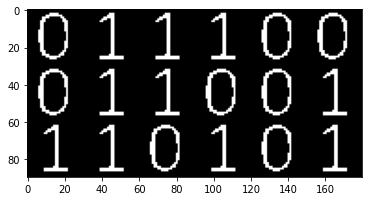

In [33]:
final_img = digits_to_image(markup, zero, one)
plt.imshow(final_img)
plt.show()